In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import string
import math
import missingno as msno

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv(r'train.csv', nrows = 100000)
test = pd.read_csv(r'test.csv')
songs = pd.read_csv(r'songs.csv')
members = pd.read_csv(r'members.csv')
extra_info = pd.read_csv(r'songs_extra_info.csv')
sample_submission = pd.read_csv(r'sample_submission.csv')

In [5]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
train.tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
99995,EedNarOVNUU5ppYW/ho+KV8V29zuf7m3+Df5qnQ9FT4=,c7bvJHblBfQGFJG+DcltwclubmlYvIRTT964Lu4WWXI=,my library,Local playlist more,local-playlist,1
99996,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,MZTwICqr12ijCeBaWeKVJZ67Bz7NI0WA4bqB1IwR4jI=,my library,Local playlist more,local-library,0
99997,vDi/nHqBu7wb+DtI2Ix4TupWQatUEFR41mDC0c8Voh8=,xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,my library,Local playlist more,local-library,1
99998,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,SoPkcfpiBjDpZSNPN3HdbPI8WAkuenayPXyBRK91T2s=,my library,Local playlist more,local-library,0
99999,n8TgRhOBw+DthR6N6ie/63yp3KHA20UVHlbK9nY9nIc=,PEEg0ODi9cPg1VXM9EOhZtV39sBJFr/9cIflhbHJ5Bs=,my library,Local playlist more,local-library,1


In [7]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
11202,frZze7pSeHJ+YTRuGx/pTM5j9cWGRtzEbHc1QBMCgj8=,6lkD/SMtVkmLVCLoihWqdtTsbJj2HLTZJRrxkPs77sM=,my library,Local playlist more,local-library,1
85267,vF5T9jTT6kuFlViqa8V4+qnBPASXquljdVAFrEdcUIw=,MRHm4o8cQxNG+0UDxH+XIO+fwX3vcm2xUsXUfBTQOD4=,my library,Local playlist more,local-library,1
40682,6aH1YAi5YwvZUHtpjEaMQwM0p4wP4XLrkWQSdXDF9L8=,Sl4r0rBS/bxQtGvR6maEyBPlElpCjmG1AJyjqs7Am58=,my library,Local playlist more,local-library,1
17880,UWq5a21XpVz9H9zDPqhQoE9Z1V8c4u+DZJqgVUMUVJg=,7mi0jB/nHV54a9MJR45FpoT+FZLKkU6tIqHZehgprbE=,my library,Local playlist more,local-library,1
91046,Rg/q8FWPCNyi/+40wIu8zxSXgEvH4phfep+rp8YxXp4=,+kqw5/nk73qpmtay3TclbWGM5bADratoNftnqaRb2ck=,discover,NaN,song-based-playlist,1
69108,bT0Q7vVfsPeyq5mESDTHRRbFyXttS0z6qPJlh6iGZKw=,VR76u2yhRVTF967eUiFhqO+xh7nC7lukY76z86lCI88=,radio,Radio,radio,1
85543,0NahxTQKegpqovvCeQIxY9oROg5fDN2X8KII7p5H+EM=,pVL67HKrL569Uo5Sdx/nc9F2KIXPsZ2g3MOQmqlR+Uk=,my library,Local playlist more,local-library,1
9154,c56y7s0ouR08WQpDM0aZUxMGciDQDrlNBBUlNk6yc2o=,WL4ipO3Mx9pxd4FMs69ha6o9541+fLeOow67Qkrfnro=,my library,Local playlist more,local-library,1
24959,Pb0GmYtyuKHe7XGDWmBAsGN0fqN2MktZDK/bjyoAwlM=,sm2uXpTA6hwLO+z5ZgQnb4KSzx2Zs3lnZSVQ4JQnCG8=,my library,Local playlist more,local-library,0
32863,pxX1jZKzM/GWopw467GKw9caw3DudoIPcP3HPbykxMU=,2ksTVz8W1y3H+oz8pE/zfXMxWof9FFFt86McdiUlXB8=,discover,Online playlist more,online-playlist,1


In [8]:
train.describe()

,target
count,100000.000000
mean,0.750680
std,0.432622
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
train.shape

(100000, 6)

In [10]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target'],
      dtype='object')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   msno                100000 non-null  object
 1   song_id             100000 non-null  object
 2   source_system_tab   99697 non-null   object
 3   source_screen_name  95727 non-null   object
 4   source_type         99805 non-null   object
 5   target              100000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


In [12]:
train.isnull().sum()

msno                     0
song_id                  0
source_system_tab      303
source_screen_name    4273
source_type            195
target                   0
dtype: int64

In [13]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [14]:
songs.tail()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
1048570,2ZRF6vTIjeJOFG0QOvQE+9L2Uhzo7prCVNIa0sBqIbA=,182044,NaN,Dragonbay,NaN,NaN,52.0
1048571,k0TIUBzWIi7l7XYyj3YRSvLVuLJ1y1z/v/LYRKpYvVg=,470158,1152|947,Massage Tribe,NaN,NaN,-1.0
1048572,+FyGIHSC23kAAF4UeTku3oquYaFYH21OWHy+eNKpNoQ=,360559,958,Antonio Vivaldi| Wolfgang Amadeus Mozart| Ludw...,Antonio Vivaldi,NaN,-1.0
1048573,LW/HYg6lUeKFxJh/0DwaivmohvW7Mwh14sWQ4dA1riU=,767652,958,Sviatoslav Richter,NaN,NaN,-1.0
1048574,n6p0LirSgOFGNz+vZ+p0ERCnj3nL8nnYS4KhtLHEmA4=,390188,2122,Joe Pass,Joe Pass,NaN,52.0


In [15]:
songs.sample(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
734981,TvCXI4NyqLjxz1rxbjs/Wi+pot+GKCyO3l6gE4PZm9I=,205218,864|857|850|843,ANISON PROJECT,茅原 万起,茅原 万起,17.0
781313,Ycec17OVeVIE9VcuZWBToYVAtXhQhl/+MZbjeDXzSuo=,196545,2022,Paper Lions,John MacPhee| Robert MacPhee| Colin Buchanan| ...,NaN,52.0
13725,4HX8FgzJfkfWrgBLVKwWAu9AG6ulUR7kEJc5aUrkEHE=,136997,2022,Maroon 5,Adam Levine,NaN,52.0
84697,975RNrbXSE8VGSHZNibXuETH5qZgKL3N5eNTRZp9IRY=,233221,NaN,Cafe Lounge,NaN,NaN,52.0
615134,cdQ4UqC14zR3n9bSN7k++h8nzhJxMmoqDzAsuaJeo0M=,160775,2122,Nat King Cole,NaN,NaN,-1.0
1033987,NJbIEoSyODsg9CuboAekIYZI0oYPKshN46QucLObJF4=,206471,958,Peter Waters,Béla Bartók,NaN,-1.0
9984,cdp2Eet+sO++9tmcFU5zmWUny8Wgas0mL+FM4LvL8t8=,213185,139,Tiggs Da Author,Adam Simon| Ellis Taylor| Clive Brooks,Adam Simon| Ellis Taylor| Clive Brooks,52.0
889574,hGRitvEGt7u7Wo49edxy8rhEaZ07yNpCUIvDXcq8nI0=,215248,1609,Flokkendof| TSL| Alberto Margheriti,NaN,NaN,-1.0
346974,Z/C22oDy3bxbsupEcbakA+lqGzaNb7QlF0vNqV7KXQ8=,190914,2022,Nouvelle Vague,NaN,NaN,52.0
463000,5XcjK9ogs/ZX1IGRwnxb5JhjO4VY8azpa66VtGRygLc=,135140,2022,Nightwish,Tuomas Holopainen,NaN,52.0


In [16]:
songs.describe()

,song_length,language
count,1.048575e+06,1.048574e+06
mean,2.476199e+05,3.117676e+01
std,1.555091e+05,2.417372e+01
min,1.850000e+02,-1.000000e+00
25%,1.884530e+05,-1.000000e+00
50%,2.289370e+05,5.200000e+01
75%,2.763170e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [17]:
songs.shape

(1048575, 7)

In [18]:
songs.columns

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')

In [19]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   song_id      1048575 non-null  object 
 1   song_length  1048575 non-null  int64  
 2   genre_ids    1011299 non-null  object 
 3   artist_name  1048575 non-null  object 
 4   composer     570554 non-null   object 
 5   lyricist     188366 non-null   object 
 6   language     1048574 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 56.0+ MB


In [20]:
songs.isnull().sum()

song_id             0
song_length         0
genre_ids       37276
artist_name         0
composer       478021
lyricist       860209
language            1
dtype: int64

In [21]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [22]:
members.tail()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,20141024,20170518
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920
34402,xH8KpzKGeNNq6dOvy51c/8VzqOiGG+m6vabhsPSDHX4=,1,0,NaN,4,20160815,20160818


In [23]:
members.sample(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
28492,+UywZkka/IbMyFhRJANXm7ui/88fOZHRmnLR3vvsxxA=,15,43,female,9,20110326,20170930
1708,4435VShO419wLOOtd6tz+gz34ueqfBVgRLq3pZ1C1xQ=,15,0,female,9,20130429,20170908
5644,5uRfa0HUum0eKewFZ8GjXynoCpzYvn5ywiGt9HWqFNA=,1,0,NaN,7,20170204,20171004
26300,1qcVM9Fz5p8CVtmY+VLfQFcqG4OK+2jALw6X8AmLvAI=,13,28,male,9,20081209,20170824
33505,D0fwxN6oiWARj25olyXp90O++6B9/rFMbkcyl3s0dE8=,1,0,NaN,9,20150824,20180221
16540,Xb7tSGxicbxfEt9Sz8RFOBzpVYOwG4R1YpcAdRT0weg=,22,29,female,3,20130427,20171003
20575,Umd/O1oToj15eDQxtqkCj/kdqc4g60m74X2rsMAywCk=,13,34,female,9,20110324,20171028
8325,KK6N8l9wlgbtgFTjF8dc30r5oFQz4jXCxULF8Uoj0YE=,1,0,NaN,4,20170112,20170115
7277,HUKBdO5mZfPy0eUya+fMJcq0R9yK2MUCoUo8j3lmSss=,1,0,NaN,7,20151110,20170910
15305,mIktEYGZTp4RXKZgfdpo3CNvH+2z2cCuRJD+YCzXEF8=,1,0,NaN,4,20170218,20170221


In [24]:
members.shape

(34403, 7)

In [25]:
members.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')

In [26]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


In [27]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [28]:
members.isnull().sum()

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [29]:
extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [30]:
extra_info.sample(10)

,song_id,name,isrc
1009516,K8fVjdiMdwiMQkt+NvDeu1hJiX4ixBGW/d7UJ3d6VE4=,Distraktion (Claudio Di Vito Mix),ITI951010262
979074,CNT4hY3w+VPd5OaJZO41YKH3rLV3HPlIXAMNHyx5RvM=,Unpleasant Surprise [ Life Is An... ],NaN
206440,pj+/LamASsAXXSvHcccQb4kb+Kn+od7PHr6cxfSLF7E=,Baby| It's Ok (Bodybangers Remix),DEE861300528
10853,irGxuPMO3mcNR7hvHmj5cFNnK7DZhyT9bHWBOwFDNs0=,REACH YOU,NaN
346038,5tGfg2QZ/qMfurZAvGLYtHE9VD7EoAYs3Fkwgt9UKgA=,Give Em Hell,ITG271200038
474379,+RCDsaKLjk3R4htqF6zfCBTKf7d4Ldk9hFOLQrcP8Yc=,Out in the Rain,TCAAY1177196
233976,8j9Eeh+h4X3tTBIy/rYuOAaOfCNwsBPGaZxJQ1ZtZ5E=,I Got You,QM35D1500008
49229,mPWWAUAl7lc71KF8paJJ7DaudRVMFEZy1Y4btDrWCAc=,My Life,USAR19900866
392750,LYUCCD0WVioma/U/GkY/KTwfbl3zcvdJ5FWCRfpom00=,Page 28,USGES1111031
448201,GEQNDA6p/t9Hy6s3ob/1b+37aQzWXsN3vSJb0ui7azA=,L'Arlésienne Suite No. 1: III. Adagietto,GBPS81500445


In [31]:
extra_info.shape

(1048575, 3)

In [32]:
extra_info.columns

Index(['song_id', 'name', 'isrc'], dtype='object')

In [33]:
extra_info.describe()

,song_id,name,isrc
count,1048575,1048573,967252
unique,1048575,614948,845834
top,fZUTP2gZJWKtPbyv2c5yTXu+SLJZ2KzD2n/86uHv36g=,Intro,GBPS81518952
freq,1,759,89


In [34]:
extra_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   song_id  1048575 non-null  object
 1   name     1048573 non-null  object
 2   isrc     967252 non-null   object
dtypes: object(3)
memory usage: 24.0+ MB


In [35]:
extra_info.isnull().sum()

song_id        0
name           2
isrc       81323
dtype: int64

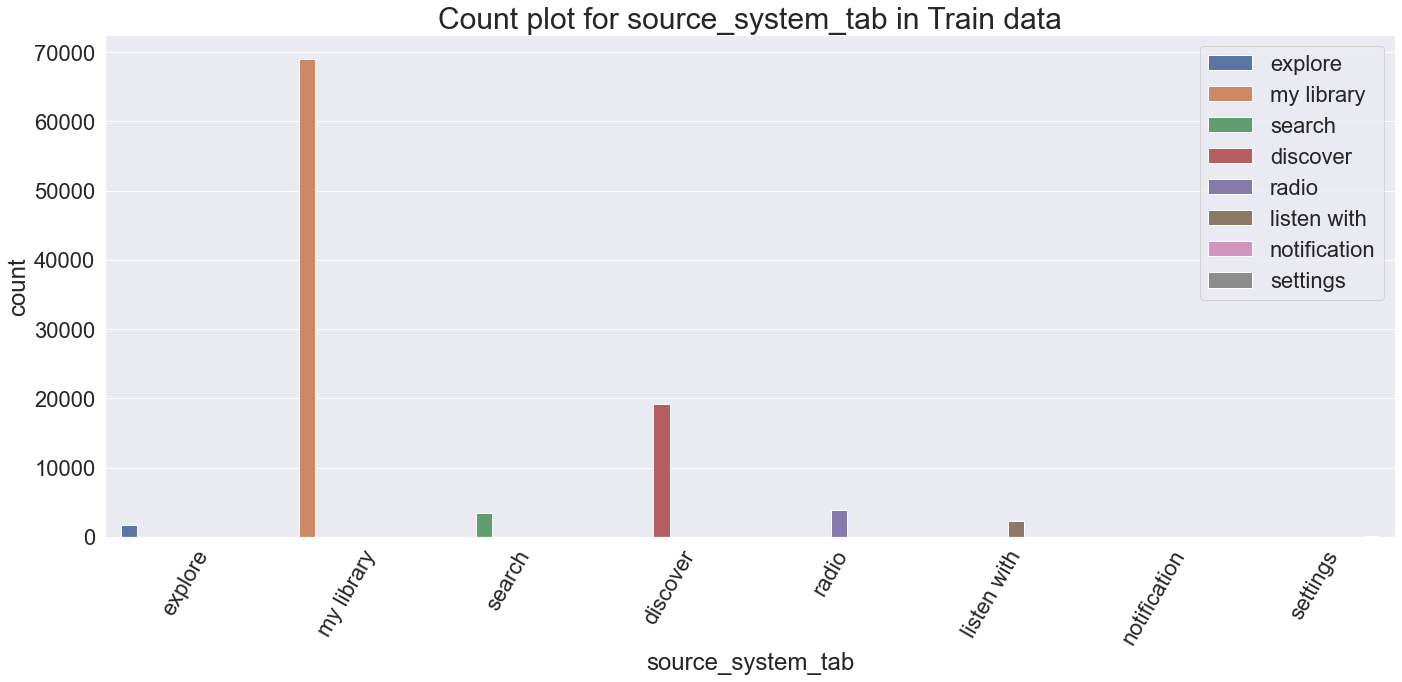

In [36]:
# Function for plotting the count plots
def count_plot(data, x, hue, type):
  plt.figure(figsize = (20, 10))
  sns.set(font_scale = 2)
  sns.countplot(x = x, hue = hue, data = data)
  plt.xlabel(x)
  plt.ylabel('count')
  plt.xticks(rotation = '60')
  plt.title('Count plot for {0} in {1} data'.format(x, type), fontsize = 30)
  plt.legend(loc='best')
  plt.tight_layout();
count_plot(train,'source_system_tab','source_system_tab','Train')

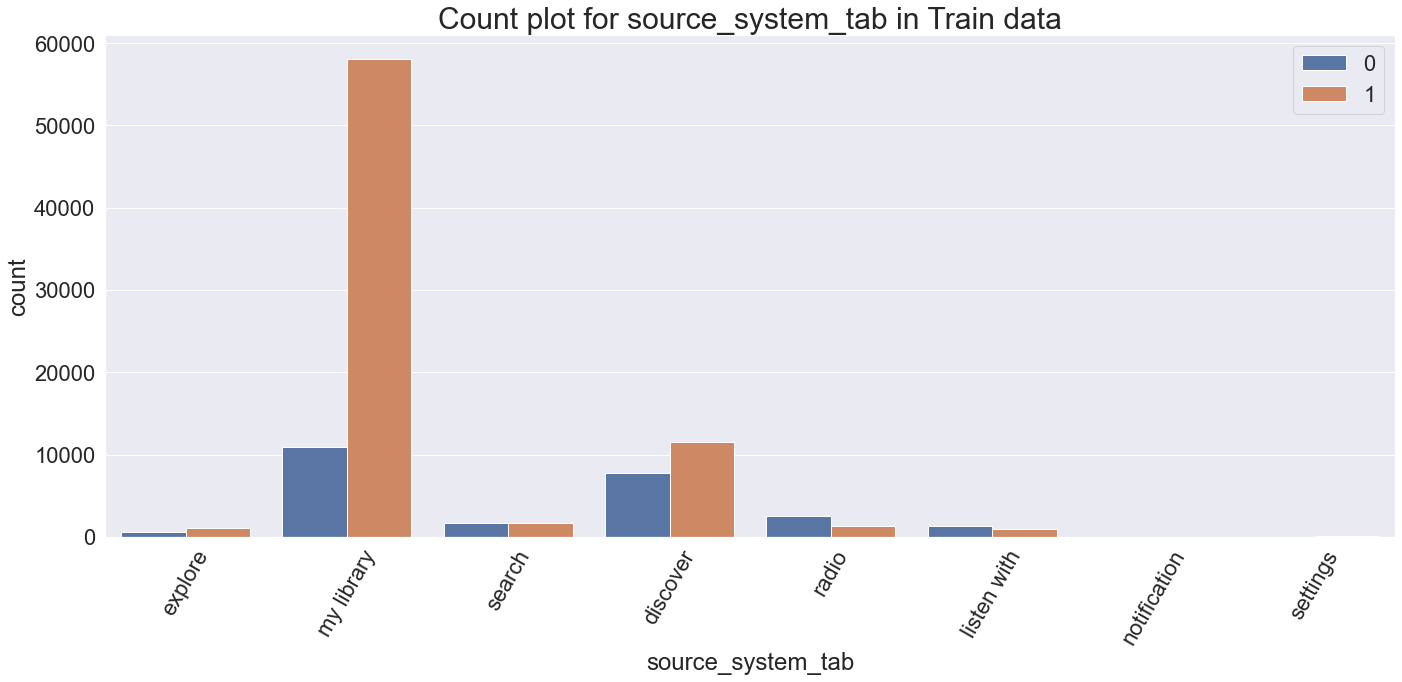

In [37]:
count_plot(train, 'source_system_tab', 'target', 'Train')

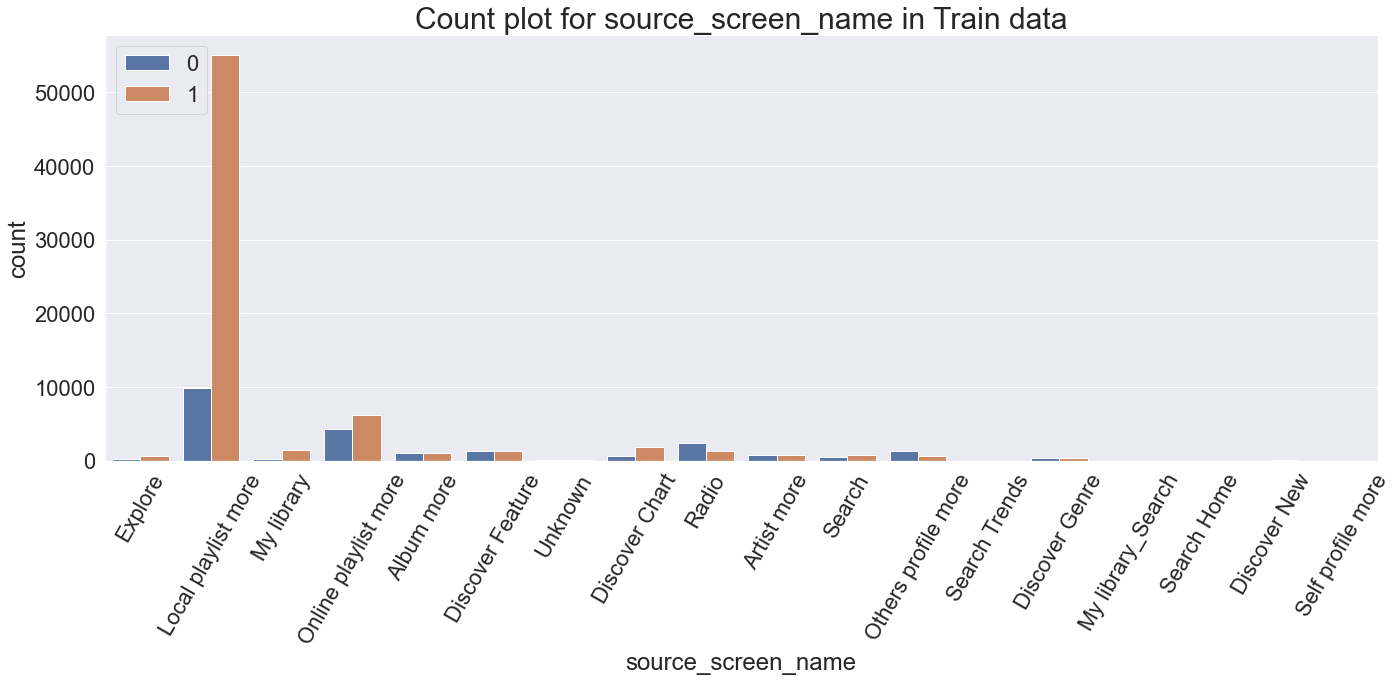

In [38]:
count_plot(train, 'source_screen_name', 'target', 'Train')

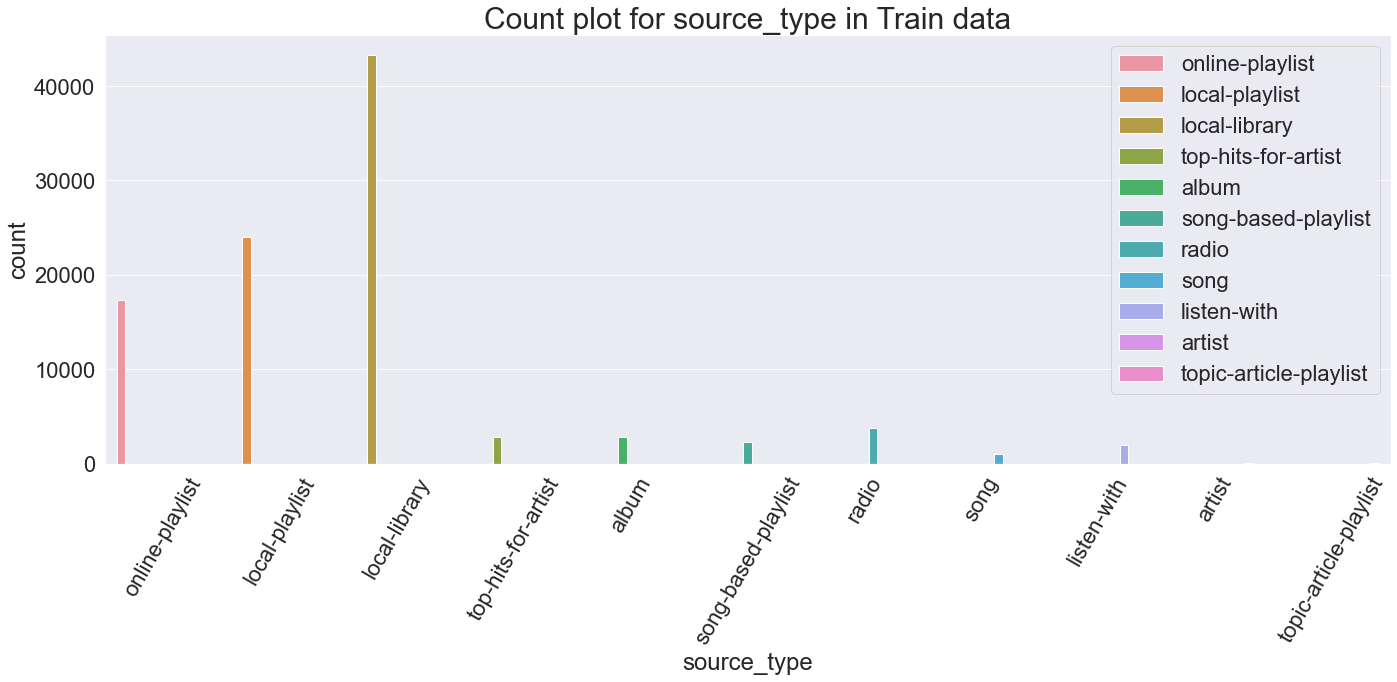

In [39]:
count_plot(train, 'source_type', 'source_type', 'Train')

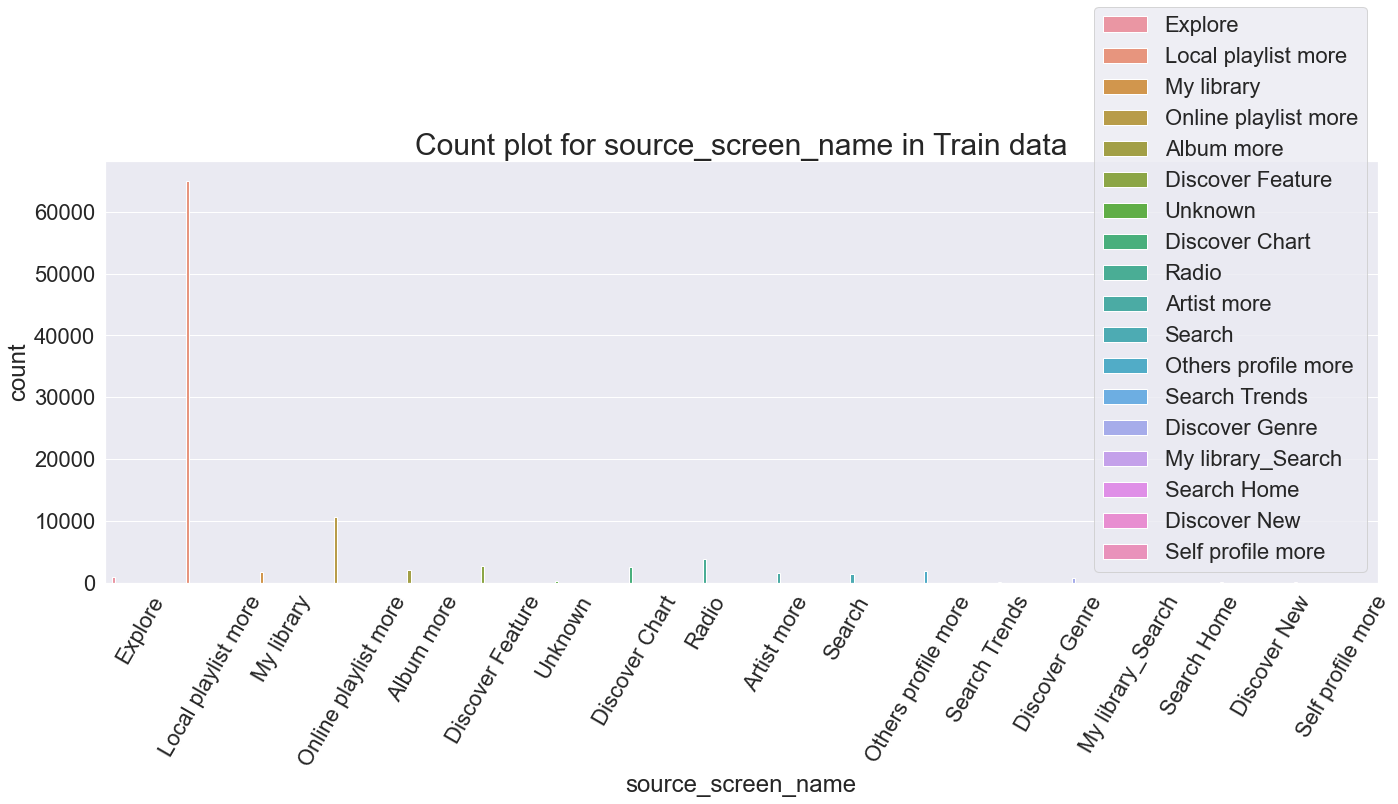

In [40]:
count_plot(train, 'source_screen_name', 'source_screen_name', 'Train')

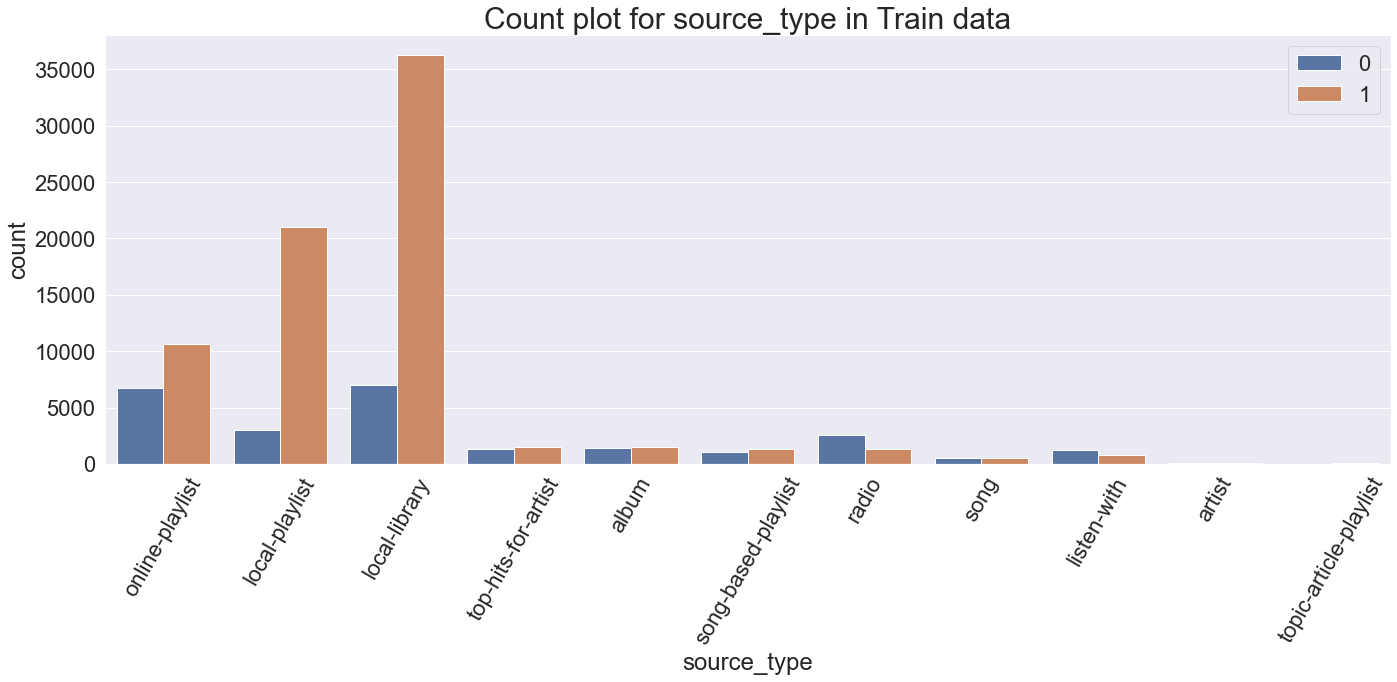

In [41]:
count_plot(train, 'source_type', 'target', 'Train')

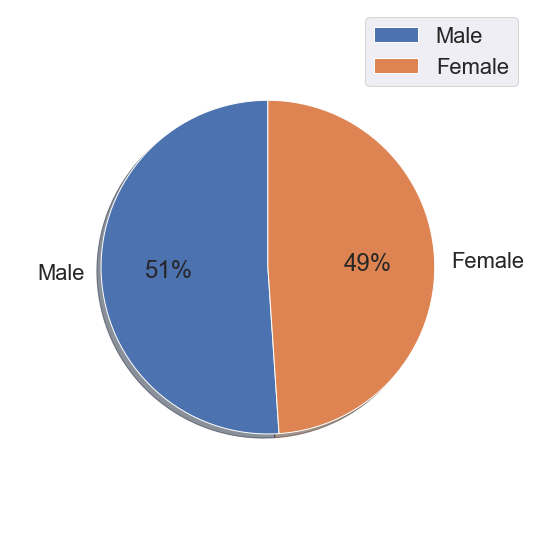

In [42]:
labels = ['Male','Female']
plt.figure(figsize = (8, 8))
sizes = pd.value_counts(members.gender)
plt.pie(sizes, 
        labels=labels, 
        autopct='%.0f%%',
        shadow=True, 
        radius=.8,
        startangle=90)
plt.legend(loc='best')
plt.tight_layout();

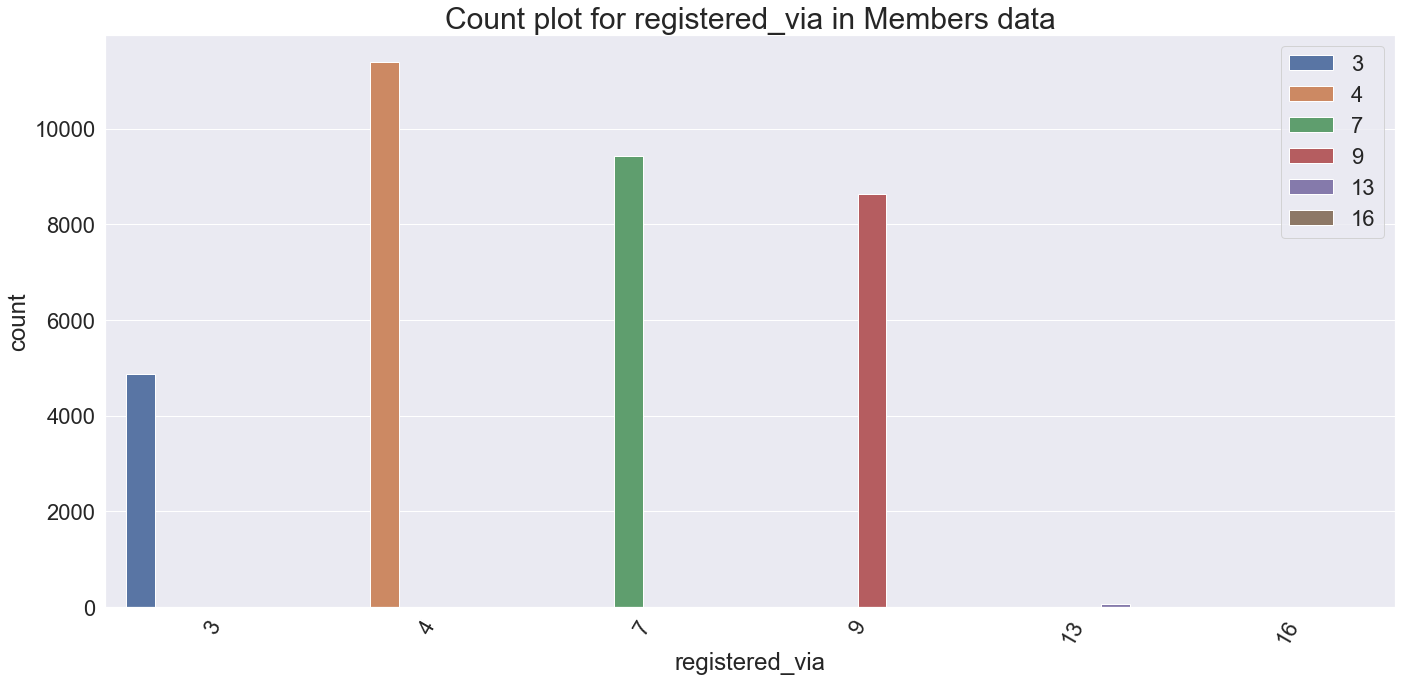

In [43]:
count_plot(members,'registered_via','registered_via', 'Members')

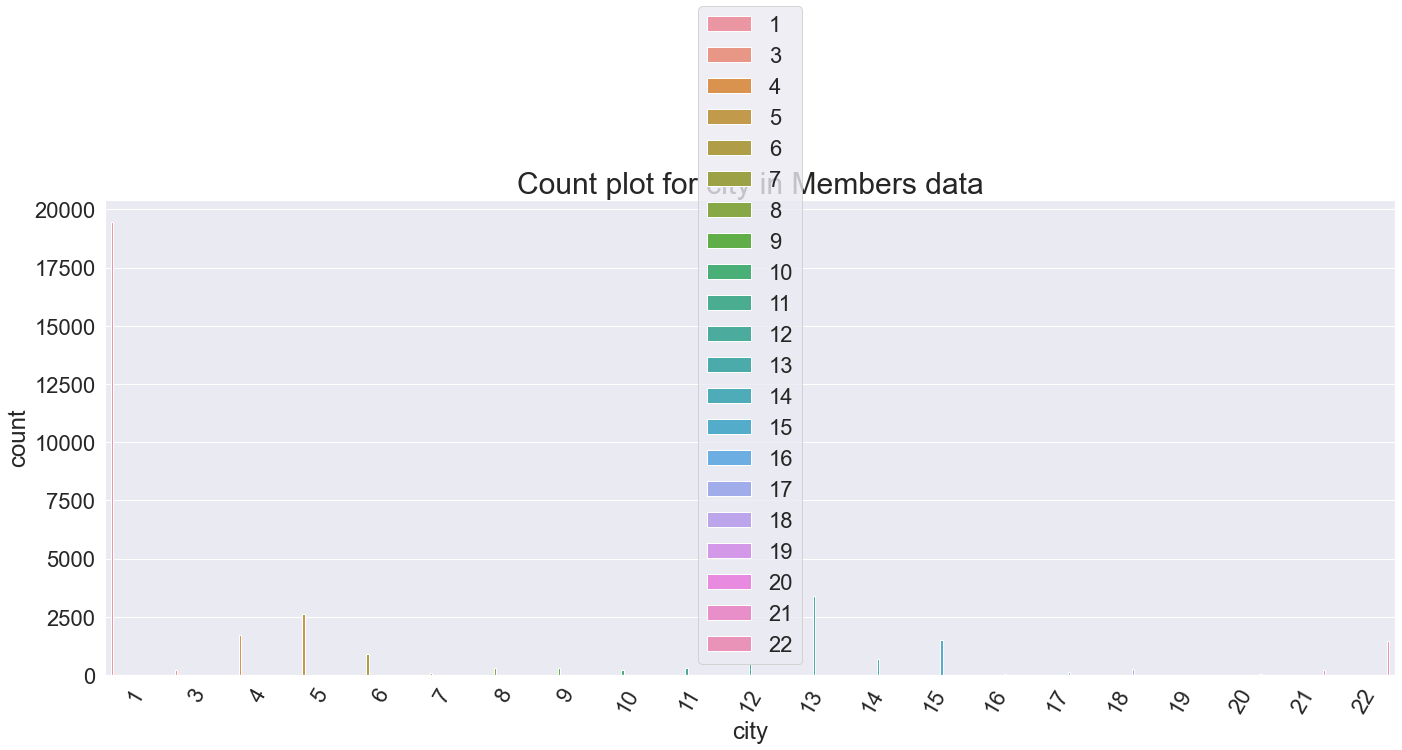

In [44]:
count_plot(members, 'city', 'city', 'Members')

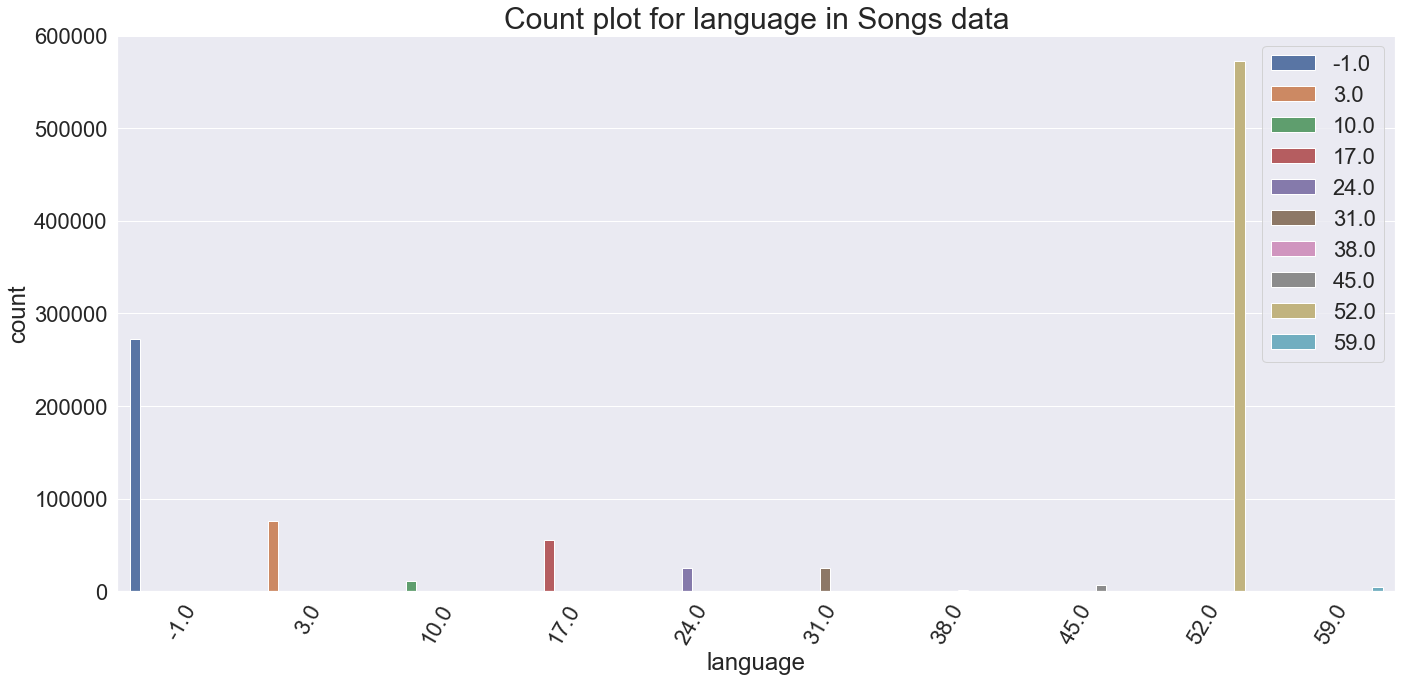

In [45]:
count_plot(songs, 'language','language', 'Songs')

In [46]:
t_s_merged = pd.merge(train, songs, on='song_id', how='left')
t_s_e_merged = pd.merge(t_s_merged, extra_info, on='song_id', how='left')
all_merged = pd.merge(t_s_e_merged, members, on='msno', how='left')

In [47]:
all_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [48]:
all_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             83012 non-null   float64
 7   genre_ids               81703 non-null   object 
 8   artist_name             83012 non-null   object 
 9   composer                65113 non-null   object 
 10  lyricist                49108 non-null   object 
 11  language                83012 non-null   float64
 12  name                    82287 non-null   object 
 13  isrc                    75244 non-null   object 
 14  city                 

In [49]:
all_merged.isnull().sum()

msno                          0
song_id                       0
source_system_tab           303
source_screen_name         4273
source_type                 195
target                        0
song_length               16988
genre_ids                 18297
artist_name               16988
composer                  34887
lyricist                  50892
language                  16988
name                      17713
isrc                      24756
city                          0
bd                            0
gender                    38672
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [50]:
all_merged.registration_init_time = pd.to_datetime(all_merged.registration_init_time, format='%Y%m%d', errors='ignore')
all_merged['registration_init_time_year'] = all_merged['registration_init_time'].dt.year
all_merged['registration_init_time_month'] = all_merged['registration_init_time'].dt.month
all_merged['registration_init_time_day'] = all_merged['registration_init_time'].dt.day

all_merged.expiration_date = pd.to_datetime(all_merged.expiration_date,  format='%Y%m%d', errors='ignore')
all_merged['expiration_date_year'] = all_merged['expiration_date'].dt.year
all_merged['expiration_date_month'] = all_merged['expiration_date'].dt.month
all_merged['expiration_date_day'] = all_merged['expiration_date'].dt.day

In [51]:
all_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,NaN,NaN,NaN,NaN,...,NaN,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,NaN,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


<AxesSubplot:>

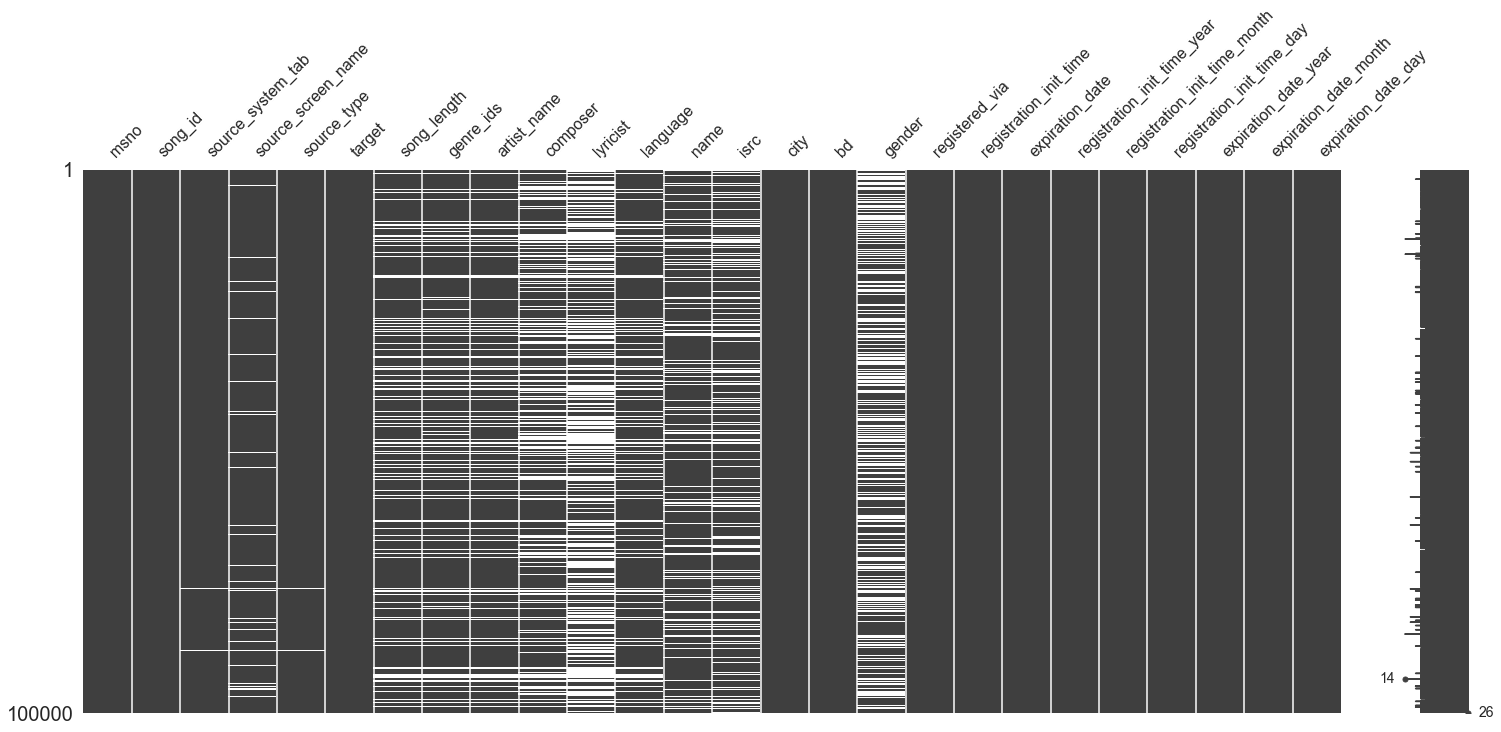

In [52]:
msno.matrix(all_merged)

In [53]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

In [54]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

In [55]:
X = all_merged.drop('target', axis=1)
y = all_merged.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("---------------------------------------------->")
    print("Training with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=100, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=100, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=100, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=100, 
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=100, 
            verbose=0
        )
    else :
        print("Model to be trained with not found.")
        model.fit( X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("-------------------------------------------->")
    print()

In [64]:
models = ['Random Forest Classifier', 'Extra Trees Classifier', 'LightGBM Classifier', 'XGBoost Classifier', 'CatBoost Classifier']

for i in models:
    model_with(i, X_train, X_val, y_train, y_val)

---------------------------------------------->
Training with : Random Forest Classifier



NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.